In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/street-view-house-number/test_32x32.mat
/kaggle/input/street-view-house-number/train_32x32.mat


## As allways load a data first.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as io
test = io.loadmat('/kaggle/input/street-view-house-number/test_32x32.mat')
train = io.loadmat('/kaggle/input/street-view-house-number/train_32x32.mat')

test.keys(), train.keys(), train["X"].shape

(dict_keys(['__header__', '__version__', '__globals__', 'X', 'y']),
 dict_keys(['__header__', '__version__', '__globals__', 'X', 'y']),
 (32, 32, 3, 73257))

## Randomize data.

In [3]:
def return_random_indices(data, max_samples=10000, seed = 10, largest_dimension=0):
    np.random.seed(seed)
    indices = np.random.choice(np.arange(data.shape[largest_dimension]),
                               max_samples,
                               replace=False)
    return indices


train_X = train["X"][..., return_random_indices(train["X"], largest_dimension=-1)]
train_y = train["y"][return_random_indices(train["y"])]
test_X = test["X"][..., return_random_indices(test["X"], 1000, largest_dimension=-1)]
test_y = test["y"][return_random_indices(test["y"], 1000)]
test_y[test_y == 10] = 0
train_y[train_y == 10] = 0

train_X = np.moveaxis(train_X, 3, 0)
test_X = np.moveaxis(test_X, 3, 0)
train_y = train_y.flatten()
test_y = test_y.flatten()

train_y.shape, train_X.shape, test_X.shape, test_y.shape

((10000,), (10000, 32, 32, 3), (1000, 32, 32, 3), (1000,))

## Visualize a slice of data.

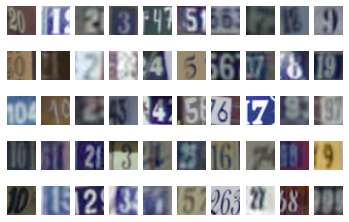

In [4]:
samples_per_class = 5  # Number of samples per class to visualize
plot_index = 1
for example_index in range(samples_per_class):
    for class_index in range(10):
        plt.subplot(5, 10, plot_index)
        image = train_X[train_y == class_index][example_index]
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

### Centering data around mean.

In [5]:
def prepare_for_neural_network(train_X, test_X):
    train_X = train_X.astype(np.float) / 255.0
    test_X = test_X.astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_X, axis = 0)
    train_X -= mean_image
    test_X -= mean_image
    
    return train_X, test_X
       
train_X, test_X = prepare_for_neural_network(train_X, test_X)

### and visualize it.

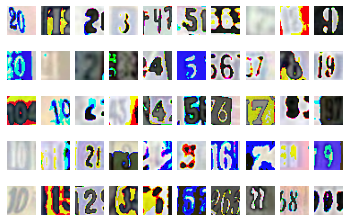

In [6]:
samples_per_class = 5  # Number of samples per class to visualize
plot_index = 1
for example_index in range(samples_per_class):
    for class_index in range(10):
        plt.subplot(5, 10, plot_index)
        image = train_X[train_y == class_index][example_index] * 255
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

We left pictures dimensions unchanged (32x32x3).

In [7]:
def random_split_train_val(X, y, num_val, seed=25):
    '''
    Randomly splits dataset into training and validation.
    
    Args:
    X (numpy array): an array of training samples.
    y (numpy array): an array of training labels.
    num_val (int): a number of samples to put into validation dataset.
    seed (int): a seed for pseudo random number generator.
    
    Returns:
    train_X (numpy array): a training dataset of samples.
    train_y (numpy array): a training dataset of labels.
    val_X (numpy array): a validation dataset of samples.
    val_y (numpy array): a validation dataset of labels.
    '''
    np.random.seed(seed)
    
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    train_indices = indices[:-num_val]
    train_X = X[train_indices]
    train_y = y[train_indices]

    val_indices = indices[-num_val:]
    val_X = X[val_indices]
    val_y = y[val_indices]

    return train_X, train_y, val_X, val_y

train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)
val_X[0, :, :, 0], val_y[:10]

(array([[0.27496353, 0.27467922, 0.27831216, ..., 0.25123725, 0.25102157,
         0.24267333],
        [0.27766784, 0.28135373, 0.28098314, ..., 0.26237255, 0.25404706,
         0.24944745],
        [0.28042706, 0.28398314, 0.28360314, ..., 0.26529882, 0.26082157,
         0.25618157],
        ...,
        [0.30506157, 0.30161098, 0.2906651 , ..., 0.28841882, 0.28736863,
         0.28695843],
        [0.30366784, 0.3004498 , 0.29724196, ..., 0.29452706, 0.29733373,
         0.28919725],
        [0.30145686, 0.29827882, 0.30314667, ..., 0.29274039, 0.29564902,
         0.28735765]]),
 array([6, 3, 3, 4, 8, 1, 5, 7, 4, 4], dtype=uint8))

## Creating layers...

## Convolutional layer.

The name [“convolutional neural network”](https://en.wikipedia.org/wiki/Convolutional_neural_network) indicates that the network employs a mathematical operation called [convolution](https://en.wikipedia.org/wiki/Convolution). Convolutional networks are a specialized type of neural networks that use convolution in place of general matrix multiplication in at least one of their layers.

In mathematics (in particular, functional analysis), [convolution](https://en.wikipedia.org/wiki/Convolution) is a mathematical operation on two functions (f and g) that produces a third function ({\displaystyle f*g}f*g) that expresses how the shape of one is modified by the other. The term convolution refers to both the result function and to the process of computing it. It is defined as the integral of the product of the two functions after one is reversed and shifted. And the integral is evaluated for all values of shift, producing the convolution function.
![formula#1](https://wikimedia.org/api/rest_v1/media/math/render/svg/a1b9e5b39a03b7d26051d12bbfb21960bafbfeb0)

![Convolution](https://upload.wikimedia.org/wikipedia/commons/6/6a/Convolution_of_box_signal_with_itself2.gif "Convolution of box signal with itself2.gif")

When programming a CNN, the input is a tensor with shape (number of images) x (image height) x (image width) x (image depth). Then after passing through a convolutional layer, the image becomes abstracted to a feature map, with shape (number of images) x (feature map height) x (feature map width) x (feature map channels). A convolutional layer within a neural network should have the following attributes:

- Convolutional kernels defined by a width and height (hyper-parameters).
- The number of input channels and output channels (hyper-parameter).
- The depth of the Convolution filter (the input channels) must be equal to the number channels (depth) of the input feature map.

Convolutional layers convolve the input and pass its result to the next layer. This is similar to the response of a neuron in the visual cortex to a specific stimulus. Each convolutional neuron processes data only for its receptive field. Although fully connected feedforward neural networks can be used to learn features as well as classify data, it is not practical to apply this architecture to images. A very high number of neurons would be necessary, even in a shallow (opposite of deep) architecture, due to the very large input sizes associated with images, where each pixel is a relevant variable. For instance, a fully connected layer for a (small) image of size 100 x 100 has 10,000 weights for each neuron in the second layer. The convolution operation brings a solution to this problem as it reduces the number of free parameters, allowing the network to be deeper with fewer parameters. For instance, regardless of image size, tiling regions of size 5 x 5, each with the same shared weights, requires only 25 learnable parameters. By using regularized weights over fewer parameters, the vanishing gradient and exploding gradient problems seen during backpropagation in traditional neural networks are avoided.

A | B
- | - 
![alt](https://cs231n.github.io/assets/nn1/neural_net2.jpeg) | ![alt](https://cs231n.github.io/assets/cnn/cnn.jpeg)

> Left: A regular 3-layer Neural Network. Right: A ConvNet arranges its neurons in three dimensions (width, height, depth), as visualized in one of the layers. Every layer of a ConvNet transforms the 3D input volume to a 3D output volume of neuron activations. In this example, the red input layer holds the image, so its width and height would be the dimensions of the image, and the depth would be 3 (Red, Green, Blue channels).

In [8]:
def get_im2col_indices(X_shape, filter_size, padding=0, stride=1):
    # First figure out what the size of the output should be
    batch_size, height, width, channels = X_shape
    assert (height + 2 * padding - filter_size[0]) % stride == 0, print(
    (height + 2 * padding - filter_size[0]) / stride)
    assert (width + 2 * padding - filter_size[1]) % stride == 0, print(
    (width + 2 * padding - filter_size[0]) / stride)
    out_height = (height + 2 * padding - filter_size[0]) // stride + 1
    out_width = (width + 2 * padding - filter_size[1]) // stride + 1
    
    i0 = np.repeat(np.arange(filter_size[0]), filter_size[1])
    i0 = np.tile(i0, channels)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(filter_size[0]), filter_size[1] * channels)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)
        
    k = np.repeat(np.arange(channels), filter_size[0] * filter_size[1]).reshape(-1, 1)
    return (i, j, k)
    
def im2col(X, filter_size, padding=0, stride=1):
    """ An implementation of im2col based on some fancy indexing """
    # Zero-pad the input
    X_padded = np.pad(X, ((0, 0), 
                         (padding, padding), (padding, padding),
                         (0, 0)), 'constant')
        
    i, j, k = get_im2col_indices(X.shape, filter_size, padding, stride)
    X_cols = X_padded[:, i, j, k]
    channels = X.shape[3]
    X_cols = X_cols.transpose(1, 2, 0).reshape(
    filter_size[0] * filter_size[1] * channels, -1)
    return X_cols
    
def col2im_indices(cols, X_shape, filter_size = (3,3), padding=0, stride=1):
    """ An implementation of col2im based on fancy indexing and np.add.at """
    batch_size, height, width, channels = X_shape
    height_padded, width_padded = height + 2 * padding, width + 2 * padding
    X_padded = np.zeros((batch_size, 
                         height_padded,
                         width_padded,
                         channels), dtype=cols.dtype)
    i, j, k = get_im2col_indices(X_shape, filter_size, padding, stride)
    cols_reshaped = cols.reshape(channels * filter_size[0] * filter_size[1],
                                 -1, batch_size)
    cols_reshaped = cols_reshaped.transpose(2, 0, 1)
    np.add.at(X_padded, (slice(None), i, j, k), cols_reshaped)
    if padding == 0:
        return X_padded
    return X_padded[:, padding:-padding, padding:-padding, :]

### [The Implementation of forward pass as Matrix Multiplication](https://cs231n.github.io/convolutional-networks/).

Note that the convolution operation essentially performs dot products between the filters and local regions of the input. A common implementation pattern of the CONV layer is to take advantage of this fact and formulate the forward pass of a convolutional layer as one big matrix multiply as follows:

- The local regions in the input image are stretched out into columns in an operation commonly called im2col. For example, if the input is [227x227x3] and it is to be convolved with 11x11x3 filters at stride 4, then we would take [11x11x3] blocks of pixels in the input and stretch each block into a column vector of size 11*11*3 = 363. Iterating this process in the input at stride of 4 gives (227-11)/4+1 = 55 locations along both width and height, leading to an output matrix X_col of im2col of size [363 x 3025], where every column is a stretched out receptive field and there are 55*55 = 3025 of them in total. Note that since the receptive fields overlap, every number in the input volume may be duplicated in multiple distinct columns.
- The weights of the CONV layer are similarly stretched out into rows. For example, if there are 96 filters of size [11x11x3] this would give a matrix W_row of size [96 x 363]. - 
- The result of a convolution is now equivalent to performing one large matrix multiply np.dot(W_row, X_col), which evaluates the dot product between every filter and every receptive field location. In our example, the output of this operation would be [96 x 3025], giving the output of the dot product of each filter at each location.
- The result must finally be reshaped back to its proper output dimension [55x55x96].

This approach has the downside that it can use a lot of memory, since some values in the input volume are replicated multiple times in X_col. However, the benefit is that there are many very efficient implementations of Matrix Multiplication that we can take advantage of (for example, in the commonly used BLAS API). Moreover, the same im2col idea can be reused to perform the pooling operation, which we discuss next.

## Let's explore im2col and col2im functions.

In [9]:
Z = np.array(range(64)).reshape(2,4,4,2)
print('Array of shape (4x4x2) is:')
print(Z[0], '\n')
print('It is the same as input (a picture in our context) in first channel:')
print(Z[0,:,:,0], '\n')
print('and second channel:')
print(Z[0,:,:,1], '\n')
print('So im2col function with filter size 2x2x2 takes: [0, 2, 8, 10] from first image\n')
print('and [1, 3, 9, 11] form second and converts it in column [0, 2, 8, 10, 1, 3, 9, 11]\n')
col = im2col(Z, filter_size = (2,2), padding = 0)
print(col)

Array of shape (4x4x2) is:
[[[ 0  1]
  [ 2  3]
  [ 4  5]
  [ 6  7]]

 [[ 8  9]
  [10 11]
  [12 13]
  [14 15]]

 [[16 17]
  [18 19]
  [20 21]
  [22 23]]

 [[24 25]
  [26 27]
  [28 29]
  [30 31]]] 

It is the same as input (a picture in our context) in first channel:
[[ 0  2  4  6]
 [ 8 10 12 14]
 [16 18 20 22]
 [24 26 28 30]] 

and second channel:
[[ 1  3  5  7]
 [ 9 11 13 15]
 [17 19 21 23]
 [25 27 29 31]] 

So im2col function with filter size 2x2x2 takes: [0, 2, 8, 10] from first image

and [1, 3, 9, 11] form second and converts it in column [0, 2, 8, 10, 1, 3, 9, 11]

[[ 0 32  2 34  4 36  8 40 10 42 12 44 16 48 18 50 20 52]
 [ 2 34  4 36  6 38 10 42 12 44 14 46 18 50 20 52 22 54]
 [ 8 40 10 42 12 44 16 48 18 50 20 52 24 56 26 58 28 60]
 [10 42 12 44 14 46 18 50 20 52 22 54 26 58 28 60 30 62]
 [ 1 33  3 35  5 37  9 41 11 43 13 45 17 49 19 51 21 53]
 [ 3 35  5 37  7 39 11 43 13 45 15 47 19 51 21 53 23 55]
 [ 9 41 11 43 13 45 17 49 19 51 21 53 25 57 27 59 29 61]
 [11 43 13 45 15 47 19 5

In [10]:
class Param:
    """
    Trainable parameters of the model.
    Captures both parameter value and the gradient.
    """

    def __init__(self, value):
        self.value = value
        self.grad = np.zeros_like(value)
        
class ConvolutionalLayer:
    def __init__(self, in_channels, out_channels,
                 filter_size, padding, stride=1):
        '''
        Initializes the layer.
        
        Args:
        in_channels (int): number of input channels.
        out_channels (int): number of output channels.
        filter_size (int): size of the convolutional filter.
        padding (int): number of 'pixels' to pad on each side.
        '''

        self.filter_size = int(filter_size)
        self.in_channels = int(in_channels)
        self.out_channels = int(out_channels)
        self.W = Param(
            np.random.randn(filter_size, filter_size,
                            in_channels, out_channels)
        )

        self.B = Param(np.zeros(out_channels))

        self.padding = int(padding)
        self.stride = int(stride)
    
    def forward(self, X):
        
        self.X, X_shape = X, X.shape
        batch_size, self.in_height, self.in_width, channels = X_shape
        
        out_height = (self.in_height - self.filter_size + 2 * self.padding) / self.stride +1
        out_width = (self.in_width - self.filter_size + 2 * self.padding) / self.stride +1
        
        if not out_height.is_integer() or not out_width.is_integer():
            raise Exception('Invalid output dimension!')
        
        out_height, out_width = int(out_height), int(out_width)
        
        W_row = np.moveaxis(self.W.value, 3, 0).reshape(self.out_channels, -1)
        self.X_col = im2col(X, (self.filter_size,self.filter_size),
                            self.padding, self.stride)

        output_col = np.dot(W_row, self.X_col) + self.B.value.reshape(-1, 1)
        output = output_col.reshape(self.out_channels, out_height, out_width, batch_size)
        self.output = output.transpose(3, 1, 2, 0)
        return self.output
            
    def backward(self, d_out):
        """
        Backward pass computes gradient with respect to input and
        accumulates gradients within self.W and self.B.
        
        Arg:
        d_out (numpy array (batch_size, n_output)): gradient
           of loss function with respect to output.
        
        Returns:
        d_input (numpy array (batch_size, n_input)): gradient
          with respect to input.
        """
        _, out_height, out_width, out_channels = d_out.shape
        d_out_reshaped = d_out.transpose(3, 1, 2, 0).reshape(self.out_channels, -1)
        #1, 2, 0 for layer grad
#         W_row = np.moveaxis(self.W.value, 2, 0).reshape(self.in_channels, -1)
        dW = np.dot(d_out_reshaped, self.X_col.T)
        dW = dW.T
        dW = dW.reshape(self.W.value.shape)
        self.W.grad += dW
        
        W_reshaped = np.moveaxis(self.W.value, 3, 0).reshape(self.out_channels, -1)
        d_input_col = np.dot(W_reshaped.T, d_out_reshaped)
        self.d_input = col2im_indices(d_input_col, 
                                      self.X.shape,
                                      (self.filter_size, self.filter_size),
                                      self.padding,
                                      self.stride)
        
        dB = np.sum(d_out_reshaped, axis=1)
#         print(f'dB \n{dB}.\n')
#         dB = dB.reshape(self.out_channels, -1)
        self.B.grad += dB
        
        return self.d_input
    
    def params(self):
        return { 'W': self.W, 'B': self.B }

In [11]:
# TODO: Implement ConvolutionaLayer that supports only 1 output and input channel

# Note: now you're working with images, so X is 4-dimensional tensor of
# (batch_size, height, width, channels)

X = np.array([
              [
               [[1.0], [2.0]],
               [[0.0], [-1.0]]
              ]
              ,
              [
               [[0.0], [1.0]],
               [[-2.0], [-1.0]]
              ]
             ])

# Batch of 2 images of dimensions 2x2 with a single channel
print("Shape of X:",X.shape)

layer = ConvolutionalLayer(in_channels=1, out_channels=1, filter_size=2, padding=0)
print("Shape of W", layer.W.value.shape)
layer.W.value = np.zeros_like(layer.W.value)
layer.W.value[0, 0, 0, 0] = 1.0
layer.B.value = np.ones_like(layer.B.value)
result = layer.forward(X)

assert result.shape == (2, 1, 1, 1)
assert np.all(result == X[:, :1, :1, :1] + 1), "result: %s, X: %s" % (result, X[:, :1, :1, :1])


# Now let's implement multiple output channels
layer = ConvolutionalLayer(in_channels=1, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
assert result.shape == (2, 1, 1, 2), f'shape {result.shape}'


# And now multple input channels!
X = np.array([
              [
               [[1.0, 0.0], [2.0, 1.0]],
               [[0.0, -1.0], [-1.0, -2.0]]
              ]
              ,
              [
               [[0.0, 1.0], [1.0, -1.0]],
               [[-2.0, 2.0], [-1.0, 0.0]]
              ]
             ])

print("Shape of X:", X.shape)
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
assert result.shape == (2, 1, 1, 2)

Shape of X: (2, 2, 2, 1)
Shape of W (2, 2, 1, 1)
Shape of X: (2, 2, 2, 2)


## Let's implement Backpropagation.

Good intuition you can get form this [post](https://medium.com/@mayank.utexas/backpropagation-for-convolution-with-strides-8137e4fc2710) on Medium.

![backprop](https://miro.medium.com/max/788/1*QvTW-pNwJAlbfj1LrZe8JA.gif)

Let's add an helpfull functions for checking that we did everything correctly. 

In [12]:
def check_gradient(f, x, delta=1e-5, tol=1e-4, verbose=False):
    '''
    Checks the implementation of analytical gradient by comparing
    it to numerical gradient using two-point formula.
    
    Args:
      f (func): a function that receives x and computes value and gradient.
      x (numpy array of float): an initial point where gradient is checked.
      delta (float): a step to compute numerical gradient.
      tol (float): a tolerance for comparing numerical and analytical gradients.
      
    Returns:
      (bool): an indication whether gradients are match or mismatch.
    '''
    assert isinstance(x, np.ndarray)
    assert x.dtype == np.float

    fx, analytic_grad = f(x)
    analytic_grad = analytic_grad.copy()

    assert analytic_grad.shape == x.shape
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        value = x[ix]
        x[ix] = value + delta
        fx_plus_delta = f(x)
        x[ix] = value - delta
        fx_minus_delta = f(x)
        x[ix] = value # restore value
        grad[ix] = (fx_plus_delta[0] - fx_minus_delta[0]) / (2 * delta)
        
        if verbose:
            print(ix, grad[ix])
        
        analytic_grad_at_ix = analytic_grad[ix]
        numeric_grad_at_ix = grad[ix]

        if not np.isclose(numeric_grad_at_ix, analytic_grad_at_ix, tol):
            print("Gradients are different at %s. Analytic: %2.5f, Numeric: %2.5f" % (
                  ix, analytic_grad_at_ix, numeric_grad_at_ix))
            return False
        it.iternext()
    print("Gradient check passed!")
    return True #grad, analytic_grad #
    
def check_layer_gradient(layer, x, delta=1e-5, tol=1e-4, verbose=False):
    """
    Checks gradient correctness for the input and output of a layer
    Arguments:
      layer: neural network layer, with forward and backward functions
      x: starting point for layer input
      delta: step to compute numerical gradient
      tol: tolerance for comparing numerical and analytical gradient
    Returns:
      bool indicating whether gradients match or not
    """
    output = layer.forward(x)
    output_weight = np.random.randn(*output.shape)

    def helper_func(x):
        output = layer.forward(x)
        loss = np.sum(output * output_weight)
        d_out = np.ones_like(output) * output_weight
        grad = layer.backward(d_out)
        return loss, grad

    return check_gradient(helper_func, x, delta, tol, verbose)

def check_layer_param_gradient(layer, x,
                               param_name,
                               delta=1e-5, tol=1e-4):
    """
    Checks gradient correctness for the parameter of the layer.
    
    Args:
      layer (class): neural network layer, with forward and backward functions.
      x (numpy array): starting point for layer input.
      param_name (class param): name of the parameter.
      delta (float): step to compute numerical gradient.
      tol (float): tolerance for comparing numerical and analytical gradient.
      
    Returns:
      bool: indicating whether gradients match or not.
    """
    param = layer.params()[param_name]
    initial_w = param.value

    output = layer.forward(x)
    output_weight = np.random.randn(*output.shape)

    def helper_func(w):
        param.value = w
        output = layer.forward(x)
        loss = np.sum(output * output_weight)
        d_out = np.ones_like(output) * output_weight
        layer.backward(d_out)
        grad = param.grad
        return loss, grad

    return check_gradient(helper_func, initial_w, delta, tol)

In [13]:
# First test - check the shape is right
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
d_input = layer.backward(np.ones_like(result))
assert d_input.shape == X.shape

# Actually test the backward pass
# As usual, you'll need to copy gradient check code from the previous assignment
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
assert check_layer_gradient(layer, X)

layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
assert check_layer_param_gradient(layer, X, 'W')
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
assert check_layer_param_gradient(layer, X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


To be completely sure, let's check on small piece of data.

In [14]:
layer = ConvolutionalLayer(in_channels=3, out_channels=2, filter_size=3, padding=0)
assert check_layer_gradient(layer, train_X[:2])

Gradient check passed!


## Check that padding works in our layer...

In [15]:
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=3, padding=1)
result = layer.forward(X)
# Note this kind of layer produces the same dimensions as input
assert result.shape == X.shape,"Result shape: %s - Expected shape %s" % (result.shape, X.shape)
d_input = layer.backward(np.ones_like(result))
assert d_input.shape == X.shape
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=3, padding=1)
assert check_layer_gradient(layer, X)

Gradient check passed!


## [Max Pooling Layer](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling#:~:text=Max%20pooling%20is%20a%20sample,in%20the%20sub%2Dregions%20binned.)

Max pooling is a sample-based discretization process. The objective is to down-sample an input representation (image, hidden-layer output matrix, etc.), reducing its dimensionality and allowing for assumptions to be made about features contained in the sub-regions binned.

This is done to in part to help over-fitting by providing an abstracted form of the representation. As well, it reduces the computational cost by reducing the number of parameters to learn and provides basic translation invariance to the internal representation.

Max pooling is done by applying a max filter to (usually) non-overlapping subregions of the initial representation.

Let's say we have a 4x4 matrix representing our initial input. Let's say, as well, that we have a 2x2 filter that we'll run over our input. We'll have a stride of 2 (meaning the (dx, dy) for stepping over our input will be (2, 2)) and won't overlap regions.

For each of the regions represented by the filter, we will take the max of that region and create a new, output matrix where each element is the max of a region in the original input.

A | B
- | - 
![A](https://cs231n.github.io/assets/cnn/pool.jpeg) | ![B](https://cs231n.github.io/assets/cnn/maxpool.jpeg)

## Let's explore im2col and im2col in application for forward and backward passes in MaxPooling layer.

In [16]:
Z = np.array(range(96)).reshape(2,4,4,3)
print(f'\nLet our input in MaxPooling layer be as\nFirst dimension:\n{Z[0,:,:,0]}\n\nSecond dimension:\n{Z[0,:,:,1]}\n\nThird dimension:\n{Z[0,:,:,2]}\n')
T = Z.transpose(0,3,1,2).reshape(2*3, 4, 4, 1)
X_col = im2col(T, (2,2), 0, 2)
print(f"MaxPooling layer takes a max values inside in a border of filter shape.\nBut firstly we reshape an input in columns:\n{X_col}\n")
max_ix = np.argmax(X_col, axis=0)
output = X_col[max_ix, range(max_ix.size)]
output = output.reshape(2, 2, 2, 3).transpose(2,0,1,3)
print(f'We get: \n {output}\n\nFor first dimension:\n first channel:\n{output[0,:,:,0]}\n\nsecond channel:\n{output[0,:,:,1]}\n\n third channel:\n{output[0,:,:,2]}\n')
dT_col = np.zeros_like(X_col)
print(f"Lets visualize a backpropagation. We'll take an output of layer as input gradient.\n But first create an array of zeros with shape of X_col:\n\n{dT_col}\n")
output_flat = output.transpose(1,2,0,3).flatten()
print(f'Flattent an output (our input gradient):\n{output_flat}\n')
dT_col[max_ix, range(max_ix.size)] = output_flat
print(f'So we put an input inside of our zeros matrix in order like in X_col\n{dT_col}\n')
d_T = col2im_indices(dT_col, (2 * 3, 
                               4, 4, 1),
                                (2, 2),
                                 0, 2)
# print(f'dT\n{d_T}\n\n')
d_T = d_T.reshape(2,3,4,4).transpose(0,2,3,1)
print(f'and reshape it back:\n\n {d_T[0,:,:,0]}\n\n{d_T[0,:,:,1]}\n\n an so on...')
print('\nThe hardest thing is looking for dimensions!\n')


Let our input in MaxPooling layer be as
First dimension:
[[ 0  3  6  9]
 [12 15 18 21]
 [24 27 30 33]
 [36 39 42 45]]

Second dimension:
[[ 1  4  7 10]
 [13 16 19 22]
 [25 28 31 34]
 [37 40 43 46]]

Third dimension:
[[ 2  5  8 11]
 [14 17 20 23]
 [26 29 32 35]
 [38 41 44 47]]

MaxPooling layer takes a max values inside in a border of filter shape.
But firstly we reshape an input in columns:
[[ 0  1  2 48 49 50  6  7  8 54 55 56 24 25 26 72 73 74 30 31 32 78 79 80]
 [ 3  4  5 51 52 53  9 10 11 57 58 59 27 28 29 75 76 77 33 34 35 81 82 83]
 [12 13 14 60 61 62 18 19 20 66 67 68 36 37 38 84 85 86 42 43 44 90 91 92]
 [15 16 17 63 64 65 21 22 23 69 70 71 39 40 41 87 88 89 45 46 47 93 94 95]]

We get: 
 [[[[15 16 17]
   [21 22 23]]

  [[39 40 41]
   [45 46 47]]]


 [[[63 64 65]
   [69 70 71]]

  [[87 88 89]
   [93 94 95]]]]

For first dimension:
 first channel:
[[15 21]
 [39 45]]

second channel:
[[16 22]
 [40 46]]

 third channel:
[[17 23]
 [41 47]]

Lets visualize a backpropagation. We'll 

In [17]:
class MaxPoolingLayer:
    def __init__(self, pool_size, stride):
        '''
        Initializes the max pool
        Arguments:
        pool_size, int - area to pool
        stride, int - step size between pooling windows
        '''
        self.pool_size = pool_size
        self.stride = stride
        self.X = None

    def forward(self, X):
        
        self.X = X
        batch_size, self.in_height, self.in_width, self.in_channels = X.shape
        
        out_height = (self.in_height - self.pool_size) // self.stride +1
        out_width = (self.in_width - self.pool_size) // self.stride +1
        
        self.out_height, self.out_width = int(out_height), int(out_width)
        
        X_reshaped = X.transpose(0, 3, 1, 2).reshape(batch_size * self.in_channels,
                               self.in_height, self.in_width, 1)
        
        self.X_col = im2col(X_reshaped, (self.pool_size,self.pool_size),
                            0, self.stride)
        self.max_ix = np.argmax(self.X_col, axis=0)
        output = self.X_col[self.max_ix, range(self.max_ix.size)]
        self.output = output.reshape(self.out_height,
                                     self.out_width,
                                     batch_size,
                                     self.in_channels,).transpose(2,0,1,3)
        return self.output

    def backward(self, d_out):
        batch_size, height, width, channels = self.X.shape
        d_input_col = np.zeros_like(self.X_col)
        d_out_flatten = d_out.transpose(1,2,0,3).flatten()
        d_input_col[self.max_ix, range(self.max_ix.size)] = d_out_flatten
        d_input = col2im_indices(d_input_col, (batch_size * channels, 
                                 height, width, 1),
                                (self.pool_size, self.pool_size),
                                 0, self.stride)
#         print(f'd_input shape {d_input.shape}')
        self.d_input = d_input.reshape(batch_size, channels, height, width).transpose(0,2,3,1)
        return self.d_input

    def params(self):
        return {}

In [18]:
pool = MaxPoolingLayer(2, 2)
result = pool.forward(X)
print(f'Downsampling with pool size 2 x 2 for input data:\n{ X[0,:,:,0]}\n\n {X[0,:,:,1]}\n\n {X[1,:,:,0]}\n\n {X[1,:,:,1]}\n')
print(f'Gives a result:\n{result}\n')
assert result.shape == (2, 1, 1, 2)
assert check_layer_gradient(pool, X)

Downsampling with pool size 2 x 2 for input data:
[[ 1.  2.]
 [ 0. -1.]]

 [[ 0.  1.]
 [-1. -2.]]

 [[ 0.  1.]
 [-2. -1.]]

 [[ 1. -1.]
 [ 2.  0.]]

Gives a result:
[[[[2. 1.]]]


 [[[1. 2.]]]]

Gradient check passed!


To be sure that all works fine let's check it on tiny piece of training data.

In [19]:
pool = MaxPoolingLayer(4, 4)
result = pool.forward(train_X[:2])
print(f"Let's look up inside of result. For first channels and first image we get:\n\n{result[0,:,:,0]}\n")
assert check_layer_gradient(pool, train_X[:2])

Let's look up inside of result. For first channels and first image we get:

[[-0.10582157 -0.32956824 -0.38585961 -0.24511765 -0.18782392 -0.29381373
  -0.38031176 -0.36124824]
 [-0.09696784 -0.34071529 -0.38604235 -0.17147922 -0.07372275 -0.21458196
  -0.38690118 -0.36709216]
 [-0.08142196 -0.32491569 -0.37758039 -0.18044863 -0.06129569 -0.23785569
  -0.38329255 -0.38747294]
 [-0.10418471 -0.34695608 -0.37056745 -0.16098941 -0.06369843 -0.24458902
  -0.39167765 -0.39162431]
 [-0.12284353 -0.36715098 -0.3542549  -0.11744392 -0.05346667 -0.24481608
  -0.39068039 -0.39165725]
 [-0.12558196 -0.36979882 -0.36334392 -0.10903843 -0.05273725 -0.26084235
  -0.39536667 -0.38137725]
 [-0.12297059 -0.35859216 -0.35099176 -0.07887686 -0.03965098 -0.25351529
  -0.36331843 -0.25813255]
 [-0.11853294 -0.29962235 -0.32671529 -0.18992824 -0.17776471 -0.29994
  -0.35522784 -0.26941569]]

Gradient check passed!


## At last a Flattener layer for feeding fully connected network.
This layers simply reshape an input as for forward, as well backward passes.

In [20]:
class Flattener:
    def __init__(self):
        self.X_shape = None

    def forward(self, X):
        self.X_shape = X.shape
        return X.reshape(self.X_shape[0], 
                         self.X_shape[1] * self.X_shape[2] * self.X_shape[3])

    def backward(self, d_out):
        return d_out.reshape(self.X_shape[0], 
                             self.X_shape[1], 
                             self.X_shape[2], 
                             self.X_shape[3])

    def params(self):
        # No params!
        return {}


In [21]:
flattener = Flattener()
result = flattener.forward(X)
assert result.shape == (2,8)

assert check_layer_gradient(flattener, X)

Gradient check passed!


And for training data again:

In [22]:
flattener = Flattener()
assert check_layer_gradient(flattener, train_X[:2])

Gradient check passed!


## Let's build a model.

First add a FullyConnected Layer and ReLU layer from previous assignment. 

In [23]:
def l2_regularization(W, reg_strength):
    '''
    Computes L2 regularization loss on weights and its gradient.
    
    Args:
      W (numpy array): weights.
      reg_strength (float): regularization strength value.
      
    Returns:
      loss (single value): l2 regularization loss.
      gradient (numpy array same shape as W): gradient of weight by l2 loss.
    '''
    try:
        l2_regularization_loss = reg_strength * np.sum(np.square(W))
        gradient = 2 * reg_strength * W
        return l2_regularization_loss, gradient
    except:
        raise Exception("Not implemented!")

def softmax(input_values):
    '''
    Computes probabilities from scores.
    
    Args:
      input_values (numpy array shape (N,) or (batch_size, N)): a classifier output.
      
    Returns:
      estimated_probabilities (numpy array of the same shape as input values): an estimated probability
      for every class.
    '''
    try:
        values = input_values.copy()
        if values.ndim == 1:
            values -= np.max(values)#  shift values inside the vector for numeric stability of rapidly
                                    #  increasing exponential function.
            estimated_probabilities = np.exp(values) / np.sum(np.exp(values))
        else:
            max_values = np.max(values, axis=1).reshape(-1,1)
            values = values - max_values
            estimated_probabilities = np.exp(values) / np.sum(np.exp(values), axis = 1).reshape(values.shape[0], -1)
        
        return estimated_probabilities
    
    except:
        raise Exception("Not implemented!")


def cross_entropy_loss(estimated_distribution, target_index, epsilon=1e-12):
    '''
    Computes cross-entropy loss.
    
    Args:
      estimated_distribution (numpy array, shape (N,) or (batch_size, N)): probabilities for every class.
      target_index (numpy array of int, shape (1,) or (batch_size,)): index of the true class 
      in given sample(s), showing at which index an estimated distibution should be max.
      
    Returns:
      a single value.
    '''
    try:
        if target_index is not np.array:
            target_index = np.array(target_index)
        
        if estimated_distribution.ndim == 1:
            estimated_distribution = estimated_distribution.reshape(1,-1)
            
        rows = estimated_distribution.shape[0]
        true_distribution = np.zeros_like(estimated_distribution)
        columns = target_index.flatten()
        true_distribution[np.arange(rows), columns] = 1
        return (- np.sum(true_distribution * np.log(estimated_distribution))) / estimated_distribution.shape[0]
    except:
        raise Exception("Not implemented!")        

def softmax_with_cross_entropy(input_values, target_index):
    '''
    Computes softmax and cross-entropy loss for model predictions,
    including the gradient.
    
    Args:
      input_values (numpy array, shape (N,) or (batch_size, N)): a classifier output.
      target_index (numpy array of int, shape (1,) or (batch_size,)): an index of the true 
      class for given sample(s).
      
    Returns:
      loss (a single value): cross-entropy loss.
      gradient (numpy array, input_values.shape): a gradient of cross entopy error function
      with a softmax derivative.
    '''
    try:            
        estimated_distribution = softmax(input_values)
        loss = cross_entropy_loss(estimated_distribution, target_index)
        
        if estimated_distribution.ndim == 1:
            estimated_distribution = estimated_distribution.reshape(1,-1)
            
        rows = estimated_distribution.shape[0]
        true_distribution = np.zeros_like(estimated_distribution)
        
        if target_index is not np.array:
            target_index = np.array(target_index)
        
        columns = target_index.flatten()
        true_distribution[np.arange(rows), columns] = 1
        gradient = (estimated_distribution - true_distribution) / estimated_distribution.shape[0]
        if input_values.ndim == 1:
            gradient = gradient.reshape(input_values.shape) # done only for gradient check
        return loss, gradient
    except:
        raise Exception("Not implemented!")

class FullyConnectedLayer:
    def __init__(self, n_input, n_output):
        self.W = Param(0.001 * np.random.randn(n_input, n_output))
        self.B = Param(0.001 * np.random.randn(1, n_output))
        self.X = None

    def forward(self, X):
        try:
            output = np.dot(X, self.W.value) + self.B.value
            self.X = X
            self.output = output
            return output
        except:
            raise Exception("Not implemented!")

    def backward(self, d_out):
        """
        Backward pass computes gradient with respect to input and
        accumulates gradients within self.W and self.B.
        
        Arg:
        d_out (numpy array (batch_size, n_output)): gradient
           of loss function with respect to output.
        
        Returns:
        d_input (numpy array (batch_size, n_input)): gradient
          with respect to input.
        """
        try:
            d_input = np.dot(d_out, self.W.value.T)
            dW = np.dot(self.X.T, d_out)
            dB = np.dot(np.ones_like(self.output).T, d_out)[0].reshape(1,-1)
            self.W.grad += dW
            self.B.grad += dB
            return d_input
        except:
            raise Exception("Not implemented!")

    def params(self):
        return {'W': self.W, 'B': self.B}
    
class ReLULayer:
    def __init__(self):
        pass

    def forward(self, X):
        try:
            self.X = X # saves input data for backpropagation implementation.
            output = np.where(X > 0, X, 0) # in accordance with definition of ReLU: return X if X > 0,
            return output                  # 0 otherwise.
        except:
            raise Exception("Not implemented!")

    def backward(self, d_out):
        """
        Performs backward pass of gradient from a loss function.
        
        Args:
        d_out (numpy array (batch_size, num_features)): gradient of loss function with 
        respect to output.
        
        Returns:
        d_result (numpy array (batch_size, num_features)): gradient with respect to input.
        """
        try:
            dReLU = np.where(self.X > 0, 1, (np.where(self.X < 0, 0, self.X))) # derivative for ReLU:
            d_result = dReLU * d_out                                           # dReLU = 1 if X > 0,
            return d_result                                                    # dReLU = 0 if X <= 0.
        except:
            raise Exception("Not implemented!")

    def params(self):
        # ReLU Doesn't have any parameters
        return {}

### Create a Convolutional Network.

In [24]:
class ConvNet:
    """
    Implements a very simple conv net
    Input -> Conv[3x3] -> Relu -> Maxpool[4x4] ->
    Conv[3x3] -> Relu -> MaxPool[4x4] ->
    Flatten -> FC -> Softmax
    """
    def __init__(self, input_shape, n_output_classes, conv1_channels, conv2_channels):
        """
        Initializes the neural network
        Arguments:
        input_shape, tuple of 3 ints - image_width, image_height, n_channels
                                         Will be equal to (32, 32, 3)
        n_output_classes, int - number of classes to predict
        conv1_channels, int - number of filters in the 1st conv layer
        conv2_channels, int - number of filters in the 2nd conv layer
        """
        self.layers = [ConvolutionalLayer(in_channels=input_shape[2], 
                                          out_channels=conv1_channels, 
                                          filter_size=3, padding = 0),
                       ReLULayer(),
                       MaxPoolingLayer(pool_size=4,
                                       stride=2),
                       ConvolutionalLayer(in_channels=conv1_channels, 
                                         out_channels=conv2_channels, 
                                         filter_size=3, padding=0),
                       ReLULayer(),
                       MaxPoolingLayer(pool_size=4,
                                       stride=2),
                       Flattener(),
                       FullyConnectedLayer(n_input=5*5*conv2_channels,
                                           n_output=150),
                       ReLULayer(),
                       FullyConnectedLayer(n_input=150,
                                           n_output=n_output_classes)] #n_output=n_output_classes

    def compute_loss_and_gradients(self, X, y):
        """
        Computes total loss and updates parameter gradients
        on a batch of training examples
        Arguments:
        X, np array (batch_size, height, width, input_features) - input data
        y, np array of int (batch_size) - classes
        """
        try:
            layer_count = 0
            for layer in self.layers:
                if layer.params():
                    layer.params()["W"].grad = 0# set all gradients from previous pass to zero
                    layer.params()["B"].grad = 0
            
            self.L = Param(0) # create object of overall model parameters: input values X and gradient
            self.L.value = X  # of loss function with respect to input dL/dX
                              # found it usefull only for model gradient check.
                              # Since this function makes forward and backward pass through all layers,
                              # it is impossible to get correct gradient check for layer weights,
                              # (in case of storing weights in model param())
                              # because it treats weights as X (input vector) and pass through all
                              # layers... 
                              # Model parameters stores in layer objects.
            self.input = X
            for layer in self.layers:
                self.input = layer.forward(self.input) # makes a forward pass of input data
                    
            self.loss, self.d_input = softmax_with_cross_entropy(self.input, y)
   
            for layer in reversed(self.layers):
                self.d_input = layer.backward(self.d_input) # makes a backward pass
            
            self.L.grad = self.d_input
            return self.loss
        
        except:
            raise Exception("Not implemented!")

    def predict(self, X):
        try:
            y_pred = np.zeros(X.shape[0], np.int)
            self.input_to_predict = X
            for layer in self.layers:
                self.input_to_predict = layer.forward(self.input_to_predict) # makes a forward pass of input data
            y_pred = np.argmax(softmax(self.input_to_predict), axis=1)
            return y_pred
        except:
            raise Exception("Not implemented!")

    def params(self):
        try:
            return {"model_loss": self.L} # we aggregate weights and biases in layers objects
        except:
            raise Exception("Not implemented!")

### Check layer gradient as allways.

In [25]:
def check_model_gradient(model, X, y,
                         delta=1e-5, tol=1e-4):
    """
    Checks gradient correctness for all model parameters.
    
    Args:
      model: neural network model with compute_loss_and_gradients.
      X: batch of input data.
      y: batch of labels.
      delta: step to compute numerical gradient.
      tol: tolerance for comparing numerical and analytical gradient
    
    Returns:
      bool: indicating whether gradients match or not.
    """
    params = model.params()

    for param_key in params:
        print("Checking gradient for %s" % param_key)
        param = params[param_key]
        initial_w = param.value

        def helper_func(w):
            param.value = w
            loss = model.compute_loss_and_gradients(X, y)
            grad = param.grad
            return loss, grad

        if not check_gradient(helper_func, initial_w, delta, tol):
            return False

    return True

In [26]:
# TODO: In model.py, implement missed functions function for ConvNet model

# No need to use L2 regularization
model = ConvNet(input_shape=(32,32,3), n_output_classes=10, conv1_channels=2, conv2_channels=2)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])
loss, model.layers

(2.3032525354115565,
  <__main__.FullyConnectedLayer at 0x7f4c3aee46d0>])

In [27]:
# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for model_loss
Gradient check passed!


True

### Adding an optimizers and trainer form previous assignment.

In [28]:
from copy import deepcopy
import scipy.io as io

def multiclass_accuracy(prediction, ground_truth):
    '''
    Computes metrics for multiclass classification.
    
    Args:
        prediction (numpy array of int): model predictions.
        ground_truth (numpy array of int): true labels.
        
    Returns:
        accuracy: ratio of accurate predictions to total samples.
    '''
    confusion_matrix = np.zeros((10,10), np.int)
    index = tuple(np.array(list(zip(prediction,ground_truth))).T)
    np.add.at(confusion_matrix, index, 1) # np.ix_(prediction, ground_truth)
    accuracy = np.trace(confusion_matrix) / confusion_matrix.sum()
    return accuracy

class SGD:
    """
    Implements vanilla SGD update.
    """
    def update(self, w, d_w, learning_rate, batch_size):
        """
        Performs SGD update.
        
        Args:
        w (numpy array): weights.
        d_w (numpy array, same shape as w): gradient.
        learning_rate (float): learning rate.
        
        Returns:
        updated_weights (numpy array same shape as w): updates weights.
        """
        return w - d_w * learning_rate

class MomentumSGD:
    """
    Implements Momentum SGD update.
    """
    def __init__(self, momentum=0.9):
        self.momentum = momentum
        self.velocity = 0
    
    def update(self, w, d_w, learning_rate, batch_size):
        """
        Performs Momentum SGD update.
        
        Args:
        w (numpy array): weights.
        d_w (numpy array same shape as w): gradient.
        learning_rate (float): learning rate.
        
        Returns:
        updated_weights (numpy array same shape as w)
        """
        self.velocity = self.momentum * self.velocity - learning_rate * d_w / batch_size
        w = w + self.velocity
        return w    

class Dataset:
    """
    Utility class to hold training and validation data
    """

    def __init__(self, train_X, train_y, val_X, val_y):
        self.train_X = train_X
        self.train_y = train_y
        self.val_X = val_X
        self.val_y = val_y


class Trainer:
    """
    Trainer of the neural network models.
    Performs mini-batch SGD with the specified data, model,
    training parameters and optimization rule.
    """

    def __init__(self, model, dataset, optim,
                 num_epochs=20,
                 batch_size=20,
                 learning_rate=1e-2,
                 learning_rate_decay=1.0):
        """
        Initializes the trainer.
        
        Args:
        model: neural network model.
        dataset (instance of Dataset class): data to train on.
        optim: optimization method (SGD or MomentuSGD).
        num_epochs (int): number of epochs to train.
        batch_size (int): batch size.
        learning_rate (float): initial learning rate.
        learning_rate_decal (float): ratio for decaying learning rate for every epoch.
        """
        self.dataset = dataset
        self.model = model
        self.optim = optim
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.learning_rate_decay = learning_rate_decay

        self.optimizers = None

    def setup_optimizers(self):
        self.optimizers = {}
        layer_count = 0
        for layer in self.model.layers:
            if layer.params():
                layer_count += 1
                self.optimizers[f'{layer_count}_layer_weights'] = deepcopy(self.optim)

    def compute_accuracy(self, X, y):
        
        """
        Computes accuracy on provided data using mini-batches.
        """
        indices = np.arange(X.shape[0])
        sections = np.arange(self.batch_size, X.shape[0], self.batch_size)
        batches_indices = np.array_split(indices, sections)

        pred = np.zeros_like(y)

        for batch_indices in batches_indices:
            batch_X = X[batch_indices]
            pred_batch = self.model.predict(batch_X)
            pred[batch_indices] = pred_batch

        return multiclass_accuracy(pred, y)

    def fit(self, verbose = True):
        
        """
        Trains a model.
        """
        
        if self.optimizers is None:
            self.setup_optimizers()

        num_train = self.dataset.train_X.shape[0]

        loss_history = []
        train_acc_history = []
        val_acc_history = []
        
        for epoch in range(self.num_epochs):
            shuffled_indices = np.arange(num_train)
            np.random.shuffle(shuffled_indices)
            sections = np.arange(self.batch_size, num_train, self.batch_size)
            batches_indices = np.array_split(shuffled_indices, sections)

            batch_losses = []

            for batch_indices in batches_indices:
                batch_X = self.dataset.train_X[batch_indices]
                batch_y = self.dataset.train_y[batch_indices]
                loss = self.model.compute_loss_and_gradients(batch_X, batch_y)

                layer_count = 0
                for layer in self.model.layers:
                    param = layer.params()
                    if param:
                        layer_count += 1
                        optimizer = self.optimizers[f'{layer_count}_layer_weights']
                        param["W"].value = optimizer.update(param["W"].value, param["W"].grad, 
                                                            self.learning_rate, self.batch_size)
                
                batch_losses.append(loss)

            if np.not_equal(self.learning_rate_decay, 1.0):
                self.learning_rate = self.learning_rate_decay * self.learning_rate

            ave_loss = np.mean(batch_losses)

            train_accuracy = self.compute_accuracy(self.dataset.train_X,
                                                   self.dataset.train_y)

            val_accuracy = self.compute_accuracy(self.dataset.val_X,
                                                 self.dataset.val_y)
            if verbose:
                print("Loss: %f, Train accuracy: %f, val accuracy: %f" % 
                      (batch_losses[-1], train_accuracy, val_accuracy))

            loss_history.append(ave_loss)
            train_acc_history.append(train_accuracy)
            val_acc_history.append(val_accuracy)

        return loss_history, train_acc_history, val_acc_history

In [38]:
model = ConvNet(input_shape=(32,32,3), n_output_classes=10, conv1_channels=2, conv2_channels=2)
dataset = Dataset(train_X[:16], train_y[:16], val_X[:16], val_y[:16])
trainer = Trainer(model, dataset, MomentumSGD(), batch_size=16, learning_rate=1e-2)

loss_history, train_history, val_history = trainer.fit(verbose=False)

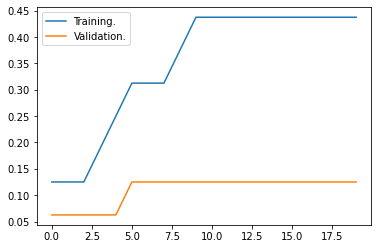

In [39]:
plt.plot(train_history, label='Training.')
plt.plot(val_history, label='Validation.')
plt.legend()

## The last exercise: overfit a model on small slice of data.

In [40]:
data_size = 512

model = ConvNet(input_shape=(32,32,3), n_output_classes=10, 
                conv1_channels=2, conv2_channels=2)
dataset = Dataset(train_X[:data_size], train_y[:data_size],
                  val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach 1.0 training accuracy in 50 epochs or less
# Hint: If you have hard time finding the right parameters manually, try grid search or random search!
trainer = Trainer(model, dataset, SGD(),
                  learning_rate=1e-1, learning_rate_decay=0.99,
                  num_epochs=100, batch_size=16)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.301504, Train accuracy: 0.128906, val accuracy: 0.136719
Loss: 2.291711, Train accuracy: 0.146484, val accuracy: 0.171875
Loss: 2.290337, Train accuracy: 0.162109, val accuracy: 0.164062
Loss: 2.266112, Train accuracy: 0.160156, val accuracy: 0.169922
Loss: 2.272445, Train accuracy: 0.162109, val accuracy: 0.164062
Loss: 2.260099, Train accuracy: 0.162109, val accuracy: 0.167969
Loss: 2.244879, Train accuracy: 0.162109, val accuracy: 0.166016
Loss: 2.343363, Train accuracy: 0.162109, val accuracy: 0.166016
Loss: 2.317842, Train accuracy: 0.162109, val accuracy: 0.167969
Loss: 2.133125, Train accuracy: 0.158203, val accuracy: 0.166016
Loss: 2.227695, Train accuracy: 0.164062, val accuracy: 0.167969
Loss: 2.228560, Train accuracy: 0.167969, val accuracy: 0.162109
Loss: 2.245215, Train accuracy: 0.166016, val accuracy: 0.169922
Loss: 2.419378, Train accuracy: 0.177734, val accuracy: 0.175781
Loss: 2.193572, Train accuracy: 0.177734, val accuracy: 0.175781
Loss: 2.389899, Train acc

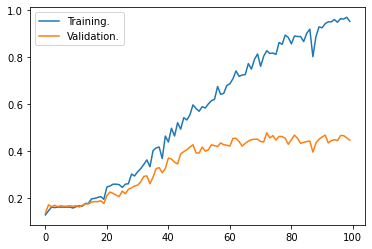

In [41]:
plt.plot(train_history, label='Training.')
plt.plot(val_history, label='Validation.')
plt.legend()